In [1]:
from functools import partial

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import chugunov_indicator as chug
from chugunov_indicator.default_data import DefaultScreeningData

In [2]:
def D_T_setup(ax) -> None:
    """Sets up the axes of a D-T graph."""

    ax.set_xlabel("$T$")
    ax.set_ylabel("$\\rho$")

    ax.set_xscale("log")
    ax.set_yscale("log")

def D_T_colorgraph(T, D, y, fig, ax) -> tuple:
    """Creates a colormesh of y-data on a D-T graph."""

    D_T_setup(ax)

    cb = ax.pcolormesh(T, D, y)
    cbar = fig.colorbar(cb)

    return cb, cbar

def clip(x: np.ndarray, maximum: float = 1.01) -> np.ndarray:
    return np.where(x > maximum, maximum, x)

In [3]:
starting_kwargs = {
    "abar": 4.028776983649795,
    "z2bar": 4.12949645671095,
    "z1": 2,
    "z2": 6
}

fixed_kwargs = {
    "zbar": 2,
    "a1": 4,
    "a2": 12
}

In [4]:
D_, T_ = np.logspace([7, 9.35], [-4, 8], num=100).T

T, D = np.meshgrid(T_, D_)

In [5]:
F = chug.chugunov_2009.chugunov_2009(T=T, D=D, **starting_kwargs, **fixed_kwargs)

In [6]:
interp = DefaultScreeningData.default_interpolator
skip_screening = partial(chug.skip_screening, interpolator=interp)

0

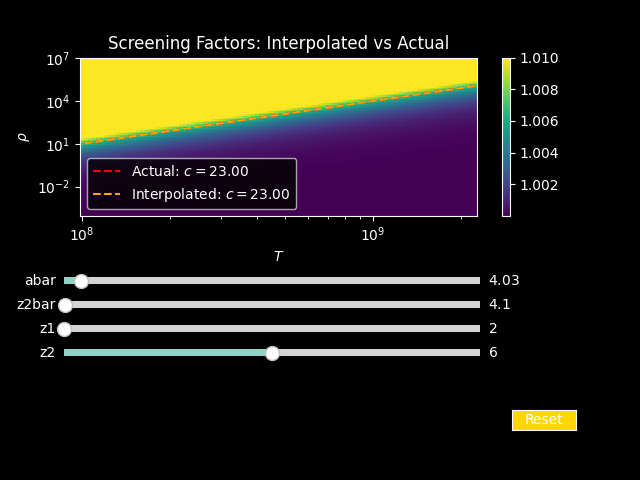

In [14]:
%matplotlib widget

fig1, ax1 = plt.subplots()
fig1.subplots_adjust(bottom=0.55)

ax1.set_title("Screening Factors: Interpolated vs Actual")

# Slider dictionaries
ax_sliders = {}
sliders = {}
maxes = {
    "abar": 52.43965444432472,
    "z2bar": 1000,
    "z1": 10,
    "z2": 10
}

# Create initial plots
c_actual, var_c_actual = 23, 0
cb, cbar = D_T_colorgraph(T, D, clip(F), fig1, ax1)

actual, = ax1.plot(T_, chug.fitting.border_func(T_, c_actual), linestyle="--", color="red")
actual.set_label(f"Actual: $c = {c_actual:.2f}$")

c_interp = 23
interpolate, = ax1.plot(T_, chug.fitting.border_func(T_, c_interp), linestyle="--", color="orange")
interpolate.set_label(f"Interpolated: $c = {c_interp:.2f}$")

ax1.legend()

# Create function to be called when slider value is changed
def update(val) -> None:
    kwargs_new = {key: sliders[key].val for key in maxes}
    F_new = chug.chugunov_2009.chugunov_2009(T, D, **kwargs_new, **fixed_kwargs)
    cb.set_array(clip(F_new))

    border_new = (1.005 < F_new) & (F_new < 1.01)
    T_border, D_border = T[border_new], D[border_new]
    
    c_actual = chug.fitting._intercept_from_border(T_border, D_border)
    actual.set_ydata(chug.fitting.border_func(T_, c_actual))
    actual.set_label(f"Actual: $c = {c_actual:.2f}$")
    
    c_interp = interp(np.array([*kwargs_new.values()])).item()
    interpolate.set_ydata(chug.fitting.border_func(T_, c_interp))
    interpolate.set_label(f"Interpolated: $c = {c_interp:.2f}$")

    ax1.legend()

for j, key in enumerate(maxes):
    # Create axes
    ax_sliders[key] = fig1.add_axes([0.1, 0.4 - j*0.05, 0.65, 0.03])
    # Create sliders
    sliders[key] = Slider(ax_sliders[key], key, 2, maxes[key], valinit=starting_kwargs[key])
    # Call update function when slider value is changed
    sliders[key].on_changed(update)

# Create axes for reset button and create button
resetax = fig1.add_axes([0.8, 0.105, 0.1, 0.04])
button = Button(resetax, 'Reset', color='gold',
                hovercolor='skyblue')
 
# Create a function resetSlider to set slider to
# initial values when Reset button is clicked
 
def resetSlider(event) -> None:
    for slider in sliders.values():
        slider.reset()
 
# Call resetSlider function when clicked on reset button
button.on_clicked(resetSlider)

# Show graph
#fig1.show()